In [42]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from datasets import load_dataset
import re
import pickle
# If you don't have NLTK on your local machine, run the command below
# nltk.download('popular')

# Loading Data

In [43]:
# FINAL DATASET: https://www.kaggle.com/datasets/elvis23/mental-health-conversational-data
with open("qa.json", 'r') as file:
    dict = json.load(file)

In [44]:
df = pd.DataFrame.from_dict(dict['intents'])
df.head()

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
1,morning,[Good morning],[Good morning. I hope you had a good night's s...
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night..."


Right now, each row contains a tag, a list of patterns, and a list of responses. It would be more useful if we can break up the rows so that it addresses only one pattern. This would be easier from a machine learning perspective so that each pattern gets its own row for the model to learn more specifically.

# Loading more data

In [45]:
dataset = load_dataset("heliosbrahma/mental_health_chatbot_dataset")

In [46]:
more_data = pd.DataFrame(columns=['tag', 'patterns', 'responses'])
#dataset['train']['text']
for i,row in enumerate(dataset['train']['text']):
    # Extract question
    human_text = re.search(r'<HUMAN>:\s*(.*)', row).group(1)
    assistant_text = re.search(r'<ASSISTANT>:\s*(.*)', row).group(1)

    # print("Text after <HUMAN>:", human_text)
    # print("Text after <ASSISTANT>:", assistant_text)
    row_data = {'tag': f"more-facts-{i}", 'patterns': human_text, 'responses': assistant_text}
    more_data = pd.concat([more_data, pd.DataFrame([row_data])], ignore_index=True)
more_data

,tag,patterns,responses
0,more-facts-0,What is a panic attack?,Panic attacks come on suddenly and involve int...
1,more-facts-1,What are symptoms of panic attack vs. anxiety ...,Panic attacks and anxiety attacks can share so...
2,more-facts-2,What are the types of Mental Illness?,There are many different conditions that are r...
3,more-facts-3,What does mental-illness mean?,Mental illness is a group of biological brain ...
4,more-facts-4,How can you treat mental illness?,The treatment of mental illness is a multi-fac...
...,...,...,...
167,more-facts-167,Who are you?,Hello there! I am your empathetic Mental Healt...
168,more-facts-168,What is the helpline number for suicide preven...,I'm really sorry but I can't provide helpline ...
169,more-facts-169,Which is the best mental health hospital in Ne...,"I'm really sorry, but I can't provide accurate..."
170,more-facts-170,Who is the best hypnotherapist in London?,I understand that you're looking for a hypnoth...


In [47]:
combined_df = pd.concat([df,more_data], ignore_index=True)
combined_df.to_csv("data.csv")
df.shape, more_data.shape, combined_df.shape

((80, 3), (172, 3), (252, 3))

# Data Augmentation

In [48]:
from transformers import AutoModelWithLMHead, AutoTokenizer
# https://huggingface.co/mrm8488/t5-small-finetuned-quora-for-paraphrasing
# pip install transformers
# pip install sentencepiece, then restart kernel

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-small-finetuned-quora-for-paraphrasing")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-small-finetuned-quora-for-paraphrasing")

def paraphrase(text, max_length=128):

  input_ids = tokenizer.encode(text, return_tensors="pt", add_special_tokens=True)

  generated_ids = model.generate(input_ids=input_ids, num_return_sequences=5, num_beams=5, max_length=max_length, no_repeat_ngram_size=2, repetition_penalty=3.5, length_penalty=1.0, early_stopping=True)

  preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]

  return preds

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/models/auto/modeling_auto.py:1699: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [49]:
for index,row in combined_df.iterrows():
    if "fact" in row['tag']:
        input_sentence = row['patterns']
        new_sentences = []
        if isinstance(input_sentence, str):
            generated_sentences = paraphrase(f"paraphrase: {input_sentence}")
            for generated in generated_sentences:
                if generated not in input_sentence:
                    new_sentences.append(generated)
            row['patterns'] = new_sentences
            # print("ROW", index)
            # print("Original", input_sentence)
            # print("NEW", row["patterns"])

In [50]:
combined_df.head()

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...
1,morning,[Good morning],[Good morning. I hope you had a good night's s...
2,afternoon,[Good afternoon],[Good afternoon. How is your day going?]
3,evening,[Good evening],[Good evening. How has your day been?]
4,night,[Good night],"[Good night. Get some proper sleep, Good night..."


In [51]:
combined_df.shape

(252, 3)

In [52]:
combined_df.to_csv('data.csv')

# Reformat the data

In [53]:
columns = dict['intents'][0].keys()

# Instantiate dataframe and load with individual rows (only one pattern in each row)
data = pd.DataFrame(columns=columns)
data.head()

new_dict = []
for index,row in combined_df.iterrows():
    for pattern in row['patterns']:
        temp_dict = {
            'tag': row['tag'],
            'patterns': pattern,
            'responses': row['responses']
        }
        new_dict.append(temp_dict)

data = pd.DataFrame.from_dict(new_dict)
data

,tag,patterns,responses
0,greeting,Hi,[Hello there. Tell me how are you feeling toda...
1,greeting,Hey,[Hello there. Tell me how are you feeling toda...
2,greeting,Is anyone there?,[Hello there. Tell me how are you feeling toda...
3,greeting,Hi there,[Hello there. Tell me how are you feeling toda...
4,greeting,Hello,[Hello there. Tell me how are you feeling toda...
...,...,...,...
1018,more-facts-170,Who is the best hypnotherapist in London? Why?,I understand that you're looking for a hypnoth...
1019,more-facts-171,Who are the best psychiatrists in Mumbai?,I understand that finding the right psychiatri...
1020,more-facts-171,Which is the best psychiatrist in Mumbai?,I understand that finding the right psychiatri...
1021,more-facts-171,Who is best psychiatrist in Mumbai?,I understand that finding the right psychiatri...


In [54]:
data = pd.concat([data, more_data])
print("Shape", data.shape)

Shape (1195, 3)


In [55]:
data.describe()

,tag,patterns,responses
count,1195,1195,1195
unique,252,1159,252
top,greeting,How can depression be treated?,[Hello there. Tell me how are you feeling toda...
freq,12,3,12


In [56]:
data.to_csv('data.csv', index=False) 

# Data Analysis

### Distribution of Tag Column

Distribution of tag column:


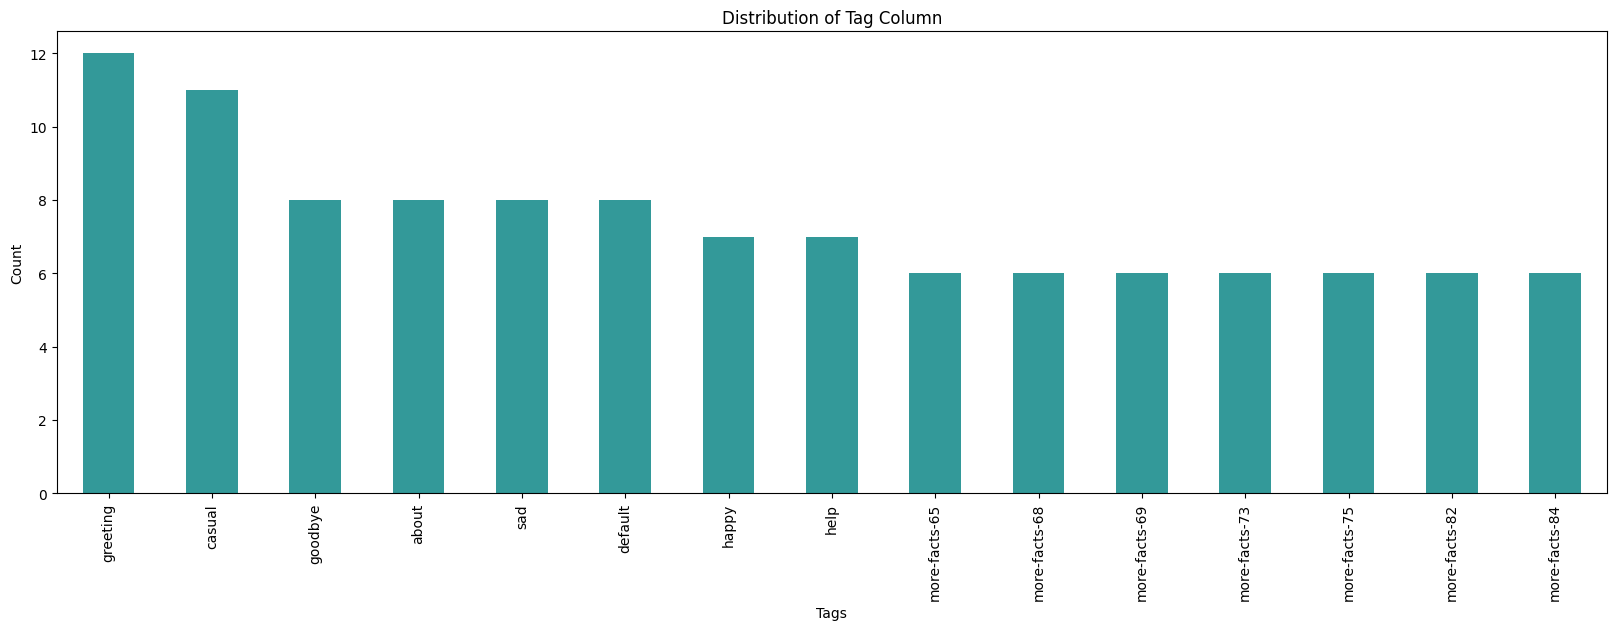

In [57]:
# Distribution of Tag Column
distribution = data['tag'].value_counts()[:15]
print("Distribution of tag column:")
distribution.plot(kind='bar', figsize=(20, 6), title="Distribution of Tag Column", color="teal", alpha=0.8)

# Add labels and title
plt.xlabel('Tags')
plt.ylabel('Count')

# Show plot
plt.show()

### Distribution of # Responses

Distribution of Responses column:


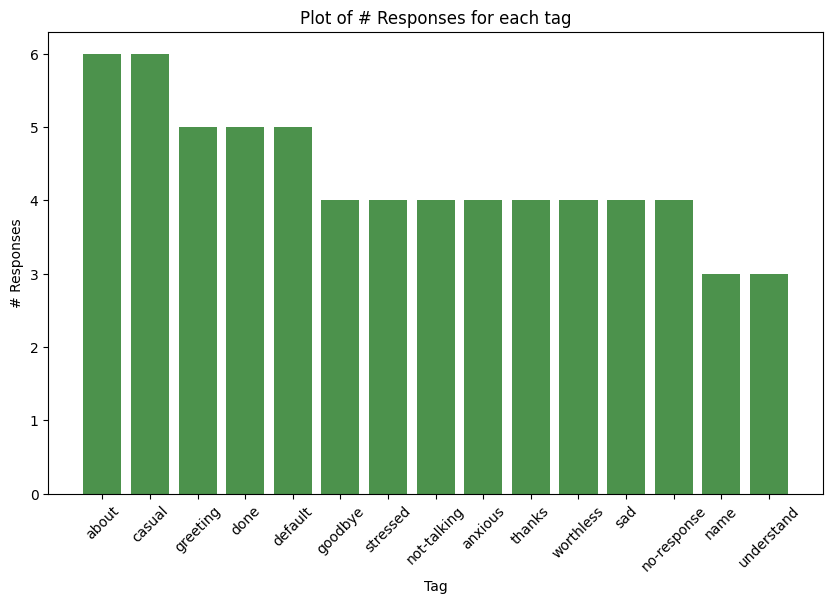

In [58]:
# Distribution of Reponses column (its length)
data_with_length = df.copy()
data_with_length['# Responses'] = data_with_length['responses'].apply(lambda x: len(x))
data_with_length = data_with_length[['tag','# Responses']]
data_with_length = data_with_length.sort_values(by='# Responses',ascending=False)
subset = data_with_length.head(15)
# data_with_length.head()

print("Distribution of Responses column:")
plt.figure(figsize=(10, 6))  
plt.bar(subset['tag'], subset['# Responses'], color="darkgreen", alpha=0.7)

# Add labels and title
plt.xlabel('Tag')
plt.ylabel('# Responses')
plt.title('Plot of # Responses for each tag')
plt.xticks(rotation=45)

# Show plot
plt.show()

# Pre-processing

In [59]:
# data = data[~data['tag'].str.contains('fact')]

In [60]:
data.head()

,tag,patterns,responses
0,greeting,Hi,[Hello there. Tell me how are you feeling toda...
1,greeting,Hey,[Hello there. Tell me how are you feeling toda...
2,greeting,Is anyone there?,[Hello there. Tell me how are you feeling toda...
3,greeting,Hi there,[Hello there. Tell me how are you feeling toda...
4,greeting,Hello,[Hello there. Tell me how are you feeling toda...


In [61]:
x = data['patterns']
y = data['tag']
print("Unique labels:", len(set(y)))

Unique labels: 252


Thoughts:
- Tokenize
- Lower-case everything
- Remove stopwords
- Lemmatize the rest

In [62]:
def preprocess_sentence(sentence):
    tokens = word_tokenize(sentence)
    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if t.isalpha() 
              and t not in stopwords.words('english')]
    wnl = WordNetLemmatizer()
    lemmas = [wnl.lemmatize(t) for t in tokens]
    unique_lemmas = list(set(lemmas))
    return unique_lemmas

In [63]:
x_mod = []
for i,row in enumerate(x):
    row_processed = preprocess_sentence(row)
    #print(i, row_processed)
    x_mod.append(' '.join(row_processed))

In [64]:
print("Length", len(x_mod))
assert len(x_mod) == len(x)

Length 1195


# Model Building

In [65]:
from sklearn.svm import SVC
X1 = data['patterns']
y1 = data['tag']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec1 = vectorizer.fit_transform(X1)
X_test_vec1 = vectorizer.transform(X_test1)

# comment out this line if training on whole X
# y1 = y_train1
with open('vectorizer.sav','wb') as f:
    pickle.dump(vectorizer,f)


In [66]:
# Train a Support Vector Machine (SVM) classifier
svc_base = SVC(random_state=2311)
# model.fit(X_train_vec1, y1)
  
svc_param_grid = {
    'C': [0.1, 0.2, 0.4, 1, 2, 4, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 0.5, 1]
}
svc_grid_search=GridSearchCV(estimator = svc_base,
                        param_grid = svc_param_grid,
                        scoring='accuracy',
                        cv=5,
                        n_jobs=-1)
svc_grid_search=svc_grid_search.fit(X_train_vec1,y1)
print("Best Parameters:", svc_grid_search.best_params_)
print("Best Score:", svc_grid_search.best_score_)

svc_model = svc_grid_search.best_estimator_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling paralleli

Best Parameters: {'C': 4, 'gamma': 1, 'kernel': 'sigmoid'}
Best Score: 0.8267782426778243


In [67]:
y_pred_svc = svc_model.predict(X_test_vec1)
# print(classification_report(y_test1, y_pred_svc))
precision = precision_score(y_test1, y_pred_svc, average="weighted")
recall = recall_score(y_test1, y_pred_svc, average="weighted")

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.9435146443514645
Recall: 0.9456066945606695


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
# Create the Multinomial Naive Bayes classifier
mnb_base = MultinomialNB()

mnb_param_grid = {
    'alpha': [0.001, 0.005, 0.1, 0.2, 0.4, 0.8, 1, 2, 4, 8, 10],
    'fit_prior': [True, False]
}
mnb_grid_search=GridSearchCV(estimator = mnb_base,
                        param_grid = mnb_param_grid,
                        scoring='accuracy',
                        cv=5,
                        n_jobs=-1)
mnb_grid_search=mnb_grid_search.fit(X_train_vec1,y1)
print("Best Parameters:", mnb_grid_search.best_params_)
print("Best Score:", mnb_grid_search.best_score_)

mnb_model = mnb_grid_search.best_estimator_



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'alpha': 0.005, 'fit_prior': True}
Best Score: 0.8301255230125524


In [69]:
with open('chatbot_model.pkl','wb') as f:
    pickle.dump(mnb_model,f)

In [70]:
# # Predict on the test set
y_pred_mnb = mnb_model.predict(X_test_vec1)
# print(classification_report(y_test1, y_pred_mnb))
precision = precision_score(y_test1, y_pred_mnb, average="weighted")
recall = recall_score(y_test1, y_pred_mnb, average="weighted")

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.9476987447698745
Recall: 0.9497907949790795


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
